<a href="https://colab.research.google.com/github/soyoung33500/Video/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EA%B0%95_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전처리

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
import sklearn
from tqdm import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras.optimizers import Adam
from tensorflow_docs.vis import embed
import imageio

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/manufacturing_bigdata/05.project01/01.video_classification/dataset/"

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")

In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True)

In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# 테스트 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
test_df = pd.read_csv(data_path + "test.csv")

In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
test_df["label"] = test_df["tag"]

In [ ]:
# enumerate(test_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(test_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    test_df["label"].replace(data, index, inplace=True)

In [ ]:
text_label = test_df["tag"].unique()

In [ ]:
# sklearn.utils.shuffle(test_df) : test_df에 저장된 행을 섞음
test_df = sklearn.utils.shuffle(test_df)

In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2)
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames = MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)

    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]

            # frame을 frames에 추가
            frames.append(frame)
        # (20, 224, 224, 3) 인 0으로 초기화된 배열 생성
        frames_arr = np.zeros((max_frames,IMG_SIZE, IMG_SIZE, 3))

        #len(frames) : 전체 프레임수를 20으로 나눈 몫
        # 전체 프레임 중에서 increase_num 씩 증가해서 리턴
        increase_num = len(frames)//max_frames
        # 0~max_frames 까지 반복
        for index in range(0, max_frames) :
            #index가 len(frames) (전체 프레임수) 이상이면 반복 종료
            if index >= len(frames):
                break
            #frames_arr에 frame[index * increase_num] 대입
            frames_arr[index] = frames[index * increase_num]

    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames_arr 를 np.uint8 타입 numpy 배열로 변환 해서 리턴
    return np.array(frames_arr, dtype=np.uint8)


In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)) # 각도 -25~25사이
])

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(translate_px = {"x": -40}), # 아핀변환
    iaa.AdditiveGaussianNoise(scale = 0.1 * 255)
    ], random_order = True)

In [ ]:
seq = iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale/zoom
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate/move
        rotate=(-25, 25), # rotate
        shear=(-8, 8)
  )  # shear
  # 움직임과 변환 회전을 이용

In [ ]:
seq = iaa.SomeOf(2, [   #  2라고 썼을때는 사진에 2개의 변화만 해당, (0, none) 이라 쓰면 0에서 전체까지의 변화 해당
    iaa.Affine(rotate = 45), # 랜덤으로 45도 회전
    iaa.AdditiveGaussianNoise(scale = 0.2 * 255),# 랜덤으로 노이즈 생성
    iaa.Add(50, per_channel = True),  # 각 채널에다가 50을 더하여 밝게 만듬
    iaa.Sharpen(alpha = 0.5)  # 사진을 더 뚜렷하게 만들어줌
    ])

In [ ]:
seq = iaa.OneOf([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Add(50, per_channel=True),
    iaa.Sharpen(alpha=0.5)
])
# 각 사진마다 4개중 단 한개만의 변화를 실행시킴

In [ ]:
seq = iaa.Sometimes(
      0.5,   # 0.5 의 확률로 아래 변화들을 실행
      iaa.GaussianBlur(sigma=2.0),   # 0 ~ 3.0의 사이즈로 블러처리
      iaa.Sequential([iaa.Affine(rotate=45), iaa.Sharpen(alpha=1.0)])
  )

In [ ]:
seq = iaa.WithChannels(0, iaa.Add((10, 100))) # 각 픽셀의 r-value 를 (10 ~ 100) 증가시킴

In [ ]:
seq = iaa.WithChannels(0, iaa.Affine(rotate=(0, 45)))  # 각 이미지의 red channel 을 (0 ~ 45) 도 증가시킴

In [ ]:
seq = iaa.AddElementwise((-40, 40))

In [ ]:
seq = iaa.AdditiveGaussianNoise(scale=0.4*255)

In [ ]:
seq = iaa.AdditiveLaplaceNoise(scale=0.2*255)

In [ ]:
seq = iaa.Multiply((0.5, 1.5))  # 각 이미지에 0.5, 1.5 를 곱하여 밝게 또는 어둡게 만듬

In [ ]:
seq = iaa.Multiply((0.5, 1.5), per_channel = 0.5)# 50 퍼센트의 확률로 각 체널에 0.5, 1.5 를 곱하여 밝게 또는 어둡게, 그리고 색도 변화시키게 만듬

In [ ]:
seq = iaa.MultiplyElementwise((0.5, 1.5), per_channel = 0.5)

In [ ]:
seq = iaa.Cutout(nb_iterations = 3) # 사진에서 3곳을 회색 픽셀로 변환

In [ ]:
seq = iaa.Cutout(nb_iterations = (1, 5), size = 0.2, squared = False, cval = 255)
# cval 은 (0 ~ 255) 검은색 ~ 흰색, (0, )

In [ ]:
seq = iaa.Cutout(fill_mode = "gaussian", fill_per_channel = True)

In [ ]:
seq = iaa.Dropout(p = (0, 0.2)) # 0 < p < 0.2 퍼센트만큼 픽셀을 드랍

In [ ]:
seq = iaa.CoarseDropout(0.02, size_percent = 0.5) # 0.02 퍼센트만큼의 픽셀을 드랍하는데, 픽셀 사이즈의 50퍼센트만큼만 드랍

In [ ]:
seq = iaa.CoarseDropout((0.0, 0.05), size_percent = (0.02, 0.25))

In [ ]:
seq = iaa.Dropout2d(p = 0.5) # 이미지 채널에 평균적으로 반을 드랍시킴

In [ ]:
seq = iaa.Invert(0.5) # 50퍼센트의 이미지를 반전시킴

In [ ]:
seq = iaa.Invert(0.25, per_channel = 0.5) # 이미지의 반은 25%의 확률로 전체 반전시키고, 나머지 반은 전체 채널에다가 각각 25%만큼 반전시킴

In [ ]:
seq = iaa.Solarize(0.5, threshold = (32, 128))  # 전체 이미지의 픽셀중 50퍼센트를 32와 128로 바꿈

In [ ]:
seq = iaa.Cartoon()  # 만화 필터를 씌움

In [ ]:
seq = iaa.BlendAlpha(
    0.5,  # 원본의 이미지의 원래 색과 회색으로 바꾼 이미지를 50:50으로 섞음
    iaa.Affine(rotate = (-20, 20)),
    per_channel = 0.5
)

In [ ]:
seq = iaa.BlendAlphaMask(   # 각 이미지에 마스크를 생성
    iaa.InvertMaskGen(0.5, iaa.VerticalLinearGradientMaskGen()),
    iaa.Clouds()
)
# 확률적으로 사진의 위나 아래에 구름모양의 블러를 생성

In [ ]:
seq = iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1.0))

In [ ]:
seq = iaa.GaussianBlur(sigma = (0.0, 3.0))
# Gaussian kernel 로 블러처리

In [ ]:
seq = iaa.AverageBlur(k = (2, 11))
# 각 사진의 주변 평균을 사용해 2x2 과 11x11 사이의 랜덤한 값으로 블러처리

In [ ]:
seq = iaa.MedianBlur(k = (3, 11))
# 각 사진의 주변 중앙값을 사용해 3x3 과 11x11 사이의 랜덤한 값으로 블러처리

In [ ]:
seq = iaa.MotionBlur(k = 15, angle = [-45, 45])
# 15 x 15 사이즈의 모션 블러를 사용하는데, 블러의 각도를 -45 45 둘중 하나의 값으로 설정

In [ ]:
seq = iaa.MeanShiftBlur()
# 피라미드 형식의 meanshiftblur을 이미지마다 적용

In [ ]:
#video 에 저장된 20개의 이미지를 증강
generate_img = seq(images=video)

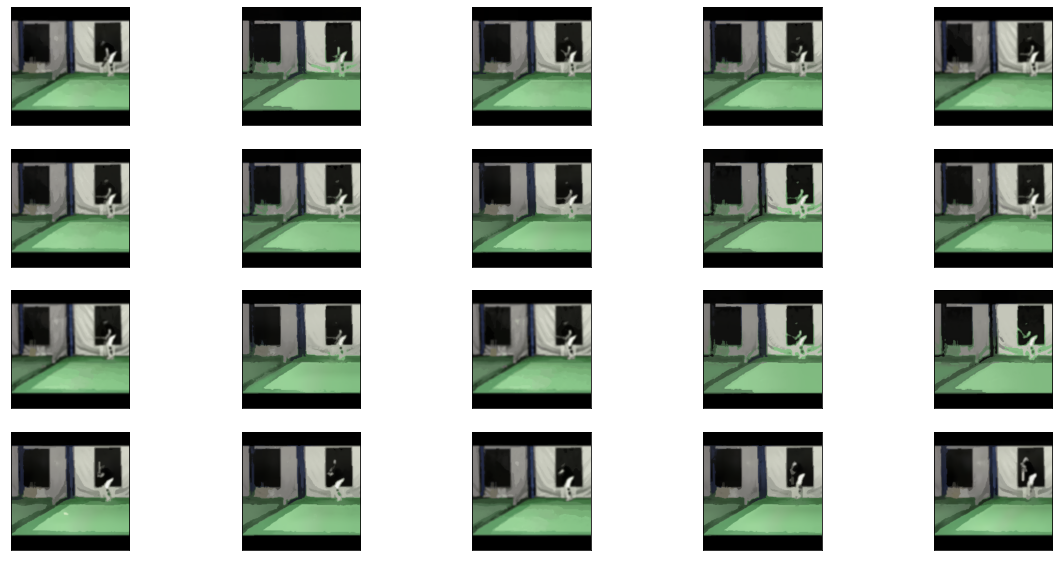

In [ ]:
#이미지를 출력할 객체

fig = plt.figure(figsize=(20, 10))

for i in range(20):
    #4줄 5칸으로 나누고 i+1번째 이미지를 그림
    subplot = fig.add_subplot(4, 5, i + 1)

    #subplot.set_xticks([]) : 그래프의 x축을 설정
    #데이터가 없으므로 x축에 아무 데이터도 출력 안됨
    subplot.set_xticks([])

    #subplot.set_yticks([]) : 그래프의 y축을 설정
    #데이터가 없으므로 y축에 아무 데이터도 출력 안됨
    subplot.set_yticks([])

    #증강된 이미지 출력 (X_train[0]을 회전 이동으로 데이터가 많은것 같은 효과를 줌)
    subplot.imshow(generate_img[i])
#그래프를 화면에 그림
plt.show()

In [ ]:
seq = iaa.SomeOf(2, [
    iaa.Affine(rotate = 45), # 랜덤으로 45도 회전
    iaa.AdditiveGaussianNoise(scale = 0.2 * 255),# 랜덤으로 노이즈 생성
    iaa.Add(50, per_channel = True), # 각 채널에다가 50을 더하여 밝게 만듬
    iaa.Sharpen(alpha = 1)
    ])

In [ ]:
#video 에 저장된 20개의 이미지를 증강
generate_img = seq(images=video)

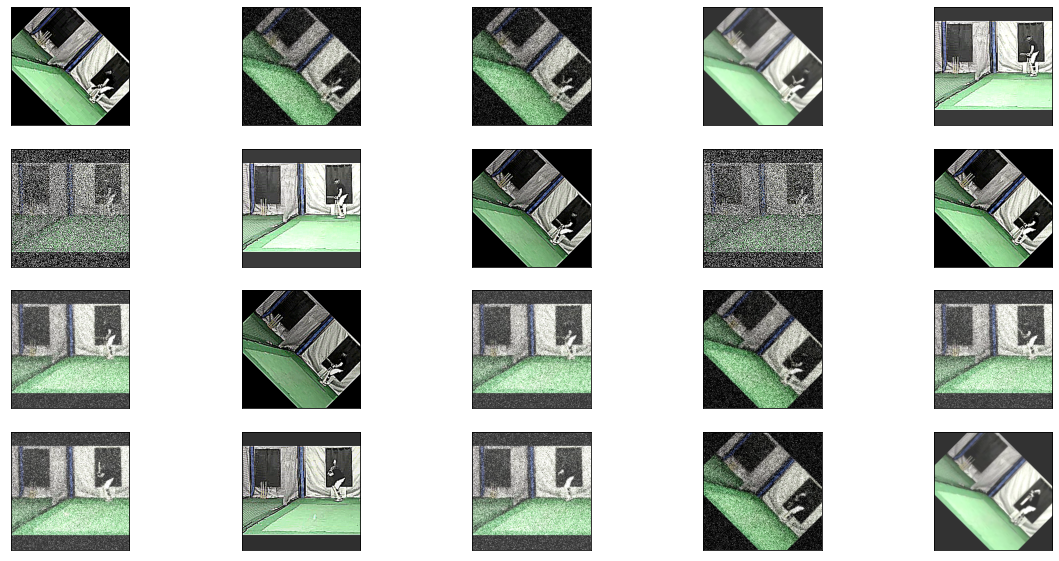

In [ ]:
#이미지를 출력할 객체

fig = plt.figure(figsize=(20, 10))

for i in range(20):
    #4줄 5칸으로 나누고 i+1번째 이미지를 그림
    subplot = fig.add_subplot(4, 5, i + 1)

    #subplot.set_xticks([]) : 그래프의 x축을 설정
    #데이터가 없으므로 x축에 아무 데이터도 출력 안됨
    subplot.set_xticks([])

    #subplot.set_yticks([]) : 그래프의 y축을 설정
    #데이터가 없으므로 y축에 아무 데이터도 출력 안됨
    subplot.set_yticks([])

    #증강된 이미지 출력 (X_train[0]을 회전 이동으로 데이터가 많은것 같은 효과를 줌)
    subplot.imshow(generate_img[i])
#그래프를 화면에 그림
plt.show()

In [ ]:
seq = iaa.Sequential([
    iaa.Resize({"height": IMG_SIZE, "width": IMG_SIZE}),
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        # Blur each image with varying strength using
        # gaussian blur (sigma between 0 and 3.0),
        # average/uniform blur (kernel size between 2x2 and 7x7)
        # median blur (kernel size between 3x3 and 11x11).
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)),
            iaa.AverageBlur(k=(2, 7)),
            iaa.MedianBlur(k=(3, 11)),
            ]),
    ),
    iaa.Sometimes(
        0.3,
        #Either drop randomly 1 to 10% of all pixels (i.e. set
        # them to black) or drop them on an image with 2-5% percent
        # of the original size, leading to large dropped
        # rectangles.
        iaa.OneOf([
            iaa.Dropout((0.01, 0.1), per_channel=0.5),
            iaa.CoarseDropout(
                (0.03, 0.15), size_percent=(0.02, 0.05),
                per_channel=0.2
            ),
        ]),
    ),
    # crop some of the images by 0-10% of their height/width
    iaa.Sometimes(0.3 ,iaa.Crop(percent=(0, 0.1))),

    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order
